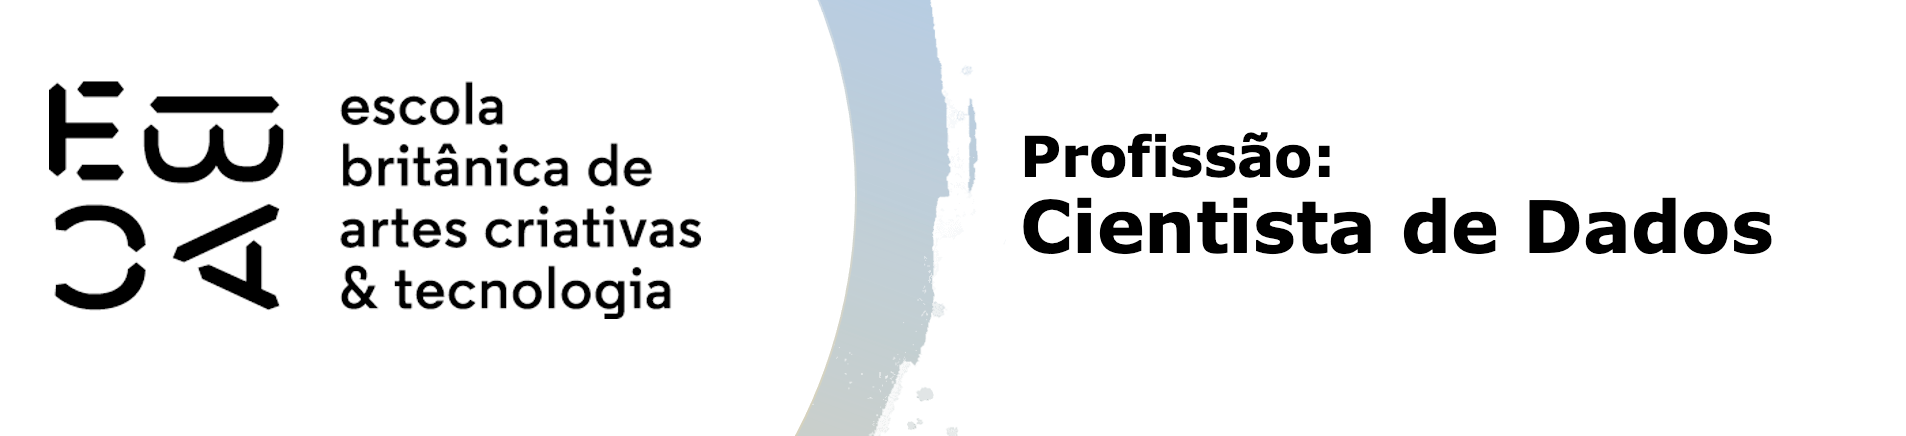

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

## Pacotes + Dataframe

In [4]:
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
import numpy               as np

from scipy.stats           import t

from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose       import ColumnTransformer
from sklearn.pipeline      import Pipeline
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import accuracy_score, roc_auc_score, roc_curve


In [5]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [7]:
df['data_ref'] = pd.to_datetime(df['data_ref'])
colunas_explicativas = df.columns.difference(['data_ref', 'index', 'mau'])

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

### Número de Linhas

In [10]:
print(f"Número total de linhas: {df.shape[0]}")

# Número de linhas por mês (safra)
linhas_por_mes = df['data_ref'].value_counts().sort_index()
print("\n\nNúmero de linhas por safra (data_ref):\n")
print(linhas_por_mes)

Número total de linhas: 750000


Número de linhas por safra (data_ref):

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


### Variaveis Qualitativas e Quantitativas

In [12]:
var_qualitativa = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
var_quantitativa = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

In [13]:
for var in var_qualitativa:
    
    values = df[var].value_counts(dropna=False)
    values_porcentagem = df[var].value_counts(normalize = True, dropna=False)
    values_porcentagem = (values_porcentagem * 100).round(2)
    
    print("Distribuição da variavel qualitativa",var,": ",values)
    print("\nProporção (%): ",values_porcentagem,"\n")
    print("------------------\n")

Distribuição da variavel qualitativa sexo :  sexo
F    504580
M    245420
Name: count, dtype: int64

Proporção (%):  sexo
F    67.28
M    32.72
Name: proportion, dtype: float64 

------------------

Distribuição da variavel qualitativa posse_de_veiculo :  posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Proporção (%):  posse_de_veiculo
N    61.06
S    38.94
Name: proportion, dtype: float64 

------------------

Distribuição da variavel qualitativa posse_de_imovel :  posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Proporção (%):  posse_de_imovel
S    67.16
N    32.84
Name: proportion, dtype: float64 

------------------

Distribuição da variavel qualitativa tipo_renda :  tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Proporção (%):  tipo_renda
Assalariado         51.43
Empresário          23.03
Pensionista         16.84
Servi

* **Problemas Encontrados**

1. Desbalanceamento de Categorias:

    * Algumas categorias têm poucas amostras *"Bolsista", "Pós graduação", "Fundamental", "Aluguel", "Estúdio", "Comunitário"*).

Isso pode dificultar a generalização do modelo para essas categorias.

Futuramente juntaremos ou excluiremos as categorias necessárias para melhoria da regresão.

In [15]:
print("\nDescrição das variáveis quantitativas:")
print(df[var_quantitativa].describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])


Descrição das variáveis quantitativas:
                          count          mean           std         min  \
qtd_filhos             750000.0      0.433251      0.739379    0.000000   
idade                  750000.0     43.804733     11.229868   22.000000   
tempo_emprego          624043.0      7.748574      6.687455    0.117808   
qt_pessoas_residencia  750000.0      2.212241      0.903428    1.000000   
renda                  750000.0  23238.544747  79106.013795  107.670000   

                               25%          50%           75%           max  
qtd_filhos                0.000000     0.000000      1.000000  1.400000e+01  
idade                    34.000000    43.000000     53.000000  6.800000e+01  
tempo_emprego             3.049315     6.046575     10.183562  4.290685e+01  
qt_pessoas_residencia     2.000000     2.000000      3.000000  1.500000e+01  
renda                  3467.700000  7861.820000  18318.280000  4.083986e+06  


* **Problemas Encontrados**

* **Outliers:**

    * Variáveis como *qtd_filhos, qt_pessoas_residencia* e renda têm valores máximos extremos que podem distorcer a análise.


* **Valores Faltantes:**

    * A variável *tempo_emprego* tem valores faltantes 

* Assimetria na Distribuição:

    * Variáveis como *renda* e *qtd_filhos* têm distribuições assimétricas, o que pode afetar o desempenho do modelo.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [18]:
for var in var_qualitativa:
    print("\n--- Variável qualitativa: ",{var}," vs mau ---")
    tabela = pd.crosstab(df[var], df['mau'])
    print("\nFrequências absolutas:")
    print(tabela)
    
    tabela_perc = pd.crosstab(df[var], df['mau'], normalize='index') * 100
    print("\nFrequências relativas (%) em cada grupo da variável:")
    print(tabela_perc.round(2))


--- Variável qualitativa:  {'sexo'}  vs mau ---

Frequências absolutas:
mau    False  True 
sexo               
F     463950  40630
M     227407  18013

Frequências relativas (%) em cada grupo da variável:
mau   False  True 
sexo              
F     91.95   8.05
M     92.66   7.34

--- Variável qualitativa:  {'posse_de_veiculo'}  vs mau ---

Frequências absolutas:
mau                False  True 
posse_de_veiculo               
N                 421872  36082
S                 269485  22561

Frequências relativas (%) em cada grupo da variável:
mau               False  True 
posse_de_veiculo              
N                 92.12   7.88
S                 92.27   7.73

--- Variável qualitativa:  {'posse_de_imovel'}  vs mau ---

Frequências absolutas:
mau               False  True 
posse_de_imovel               
N                224515  21793
S                466842  36850

Frequências relativas (%) em cada grupo da variável:
mau              False  True 
posse_de_imovel              
N   

**Conclusão Geral**

* Variáveis com Maior Impacto:
    
    1. *Posse de Imóvel*: Quem não possui imóvel tem uma proporção maior de inadimplentes.
    
    2. *Tipo de Renda*: Pensionistas e assalariados têm proporções mais altas de inadimplentes.
    
    3. *Educação*: Quem tem ensino fundamental tem uma proporção maior de inadimplentes.
    
    4. *Estado Civil*: Pessoas em união e separadas têm proporções mais altas de inadimplentes.
    
    5. *Tipo de Residência*: Quem mora com os pais ou aluga tem proporções mais altas de inadimplentes.

* Variáveis com Menor Impacto:

    1. *Sexo*: A diferença entre homens e mulheres é pequena.

    2. *Posse de Veículo*: Praticamente não há diferença entre quem possui ou não veículo.

In [20]:
for var in var_quantitativa:
    print("--- Variável quantitativa: ",{var}," vs mau ---")
    descricao = df.groupby('mau')[var].describe()
    print(descricao,'\n\n')

--- Variável quantitativa:  {'qtd_filhos'}  vs mau ---
          count      mean       std  min  25%  50%  75%   max
mau                                                          
False  691357.0  0.431739  0.737456  0.0  0.0  0.0  1.0  14.0
True    58643.0  0.451068  0.761465  0.0  0.0  0.0  1.0  14.0 


--- Variável quantitativa:  {'idade'}  vs mau ---
          count       mean        std   min   25%   50%   75%   max
mau                                                                
False  691357.0  43.896274  11.193997  22.0  35.0  43.0  53.0  68.0
True    58643.0  42.725543  11.590152  22.0  33.0  41.0  52.0  68.0 


--- Variável quantitativa:  {'tempo_emprego'}  vs mau ---
          count      mean       std       min       25%       50%        75%  \
mau                                                                            
False  575806.0  8.004300  6.807303  0.117808  3.219178  6.345205  10.556164   
True    48237.0  4.695965  3.913739  0.117808  1.715068  3.854795   6.6

* **Conclusão Geral**

* Variáveis com Maior Impacto:

    * *Tempo de Emprego*: Clientes com menos tempo de emprego têm uma probabilidade maior de inadimplência.

    * *Renda*: Clientes com menor renda têm uma probabilidade muito maior de inadimplência.

    * *Idade*: Clientes mais jovens têm uma probabilidade ligeiramente maior de inadimplência.

* Variáveis com Menor Impacto:

    * *Quantidade de Filhos*: Praticamente não há diferença entre os grupos.

    * *Quantidade de Pessoas na Residência*: Praticamente não há diferença entre os grupos.

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Log Renda

In [24]:
df['renda_log'] = np.log1p(df['renda'])

### Outliers

In [26]:
df['qtd_filhos'] = df['qtd_filhos'].clip(upper=5)  # Define um limite máximo de 5 filhos
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].clip(upper=6)  # Define um limite máximo de 6 pessoas
df['renda'] = df['renda'].clip(upper=500000)  # Define um limite máximo de 500.000 para a renda

### Valores Missing

In [28]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,6
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


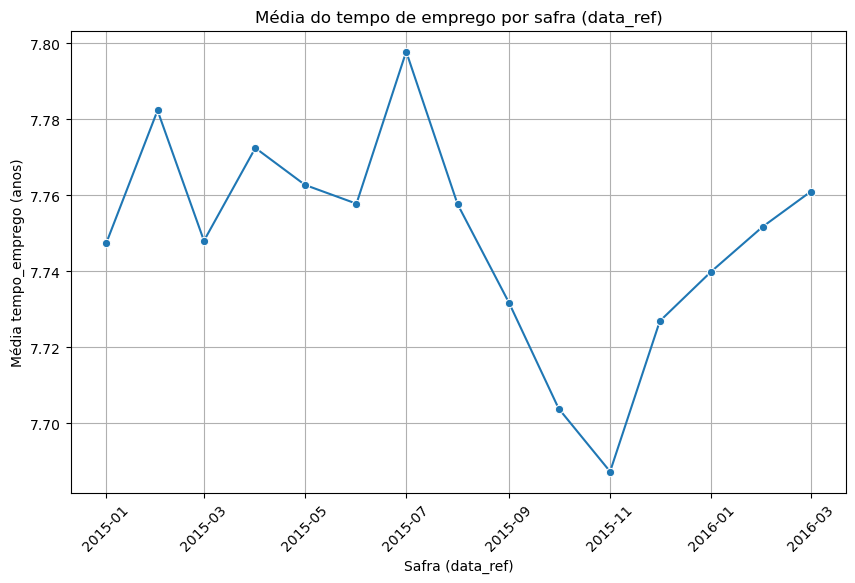

In [29]:
# Agrupa pela safra (data_ref) e calcula a média do tempo_emprego (ignorando NaN)
media_tempo_emprego = df.groupby('data_ref')['tempo_emprego'].mean()

# Plota
plt.figure(figsize=(10,6))
sns.lineplot(x=media_tempo_emprego.index, y=media_tempo_emprego.values, marker='o')
plt.title('Média do tempo de emprego por safra (data_ref)')
plt.xlabel('Safra (data_ref)')
plt.ylabel('Média tempo_emprego (anos)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

* Vamos então conferir se é melhor imputar a <span style="color: cyan;">média</span> ou <span style="color: lawngreen;">excluir</span> as linhas que possuem dados faltantes.

T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
T:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

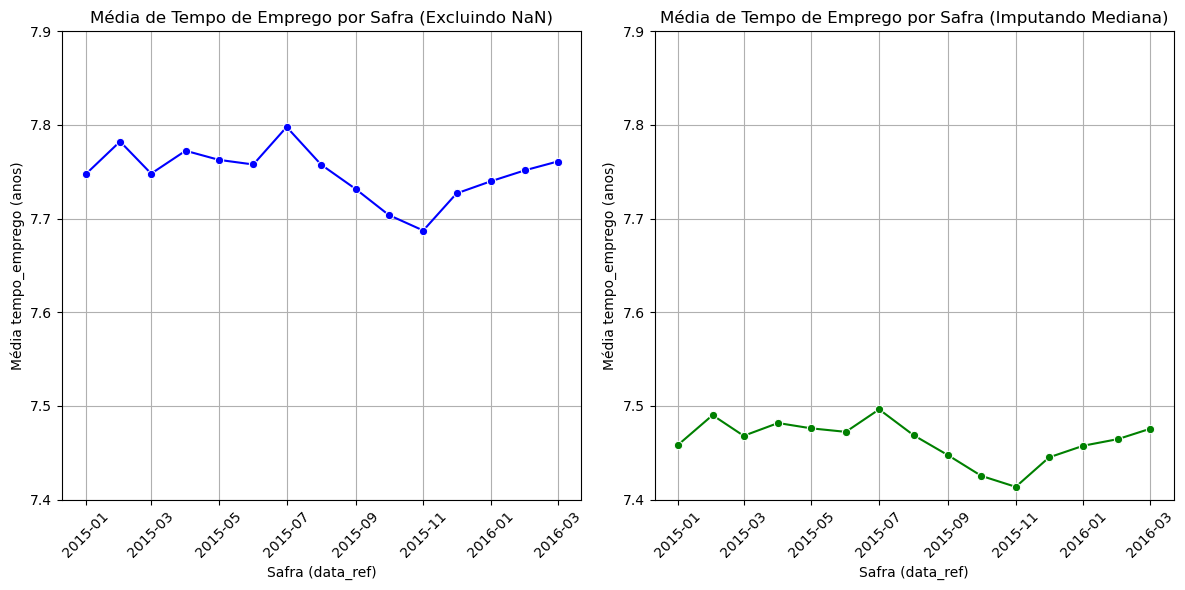

Número de linhas no df original: 750000
Número de linhas no df_drop (excluindo NaN): 624043
Número de linhas no df_median (imputando mediana): 750000


In [31]:
df_drop = df.dropna(subset=['tempo_emprego']).reset_index(drop=True)

# 2. Criar df_median (imputando a mediana nos NaN de tempo_emprego)
mediana_tempo_emprego = df['tempo_emprego'].median()
df_median = df.copy()
df_median['tempo_emprego'] = df_median['tempo_emprego'].fillna(mediana_tempo_emprego)

# 3. Plotar a média de tempo_emprego por safra para df_drop
media_tempo_emprego_drop = df_drop.groupby('data_ref')['tempo_emprego'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=media_tempo_emprego_drop.index, y=media_tempo_emprego_drop.values, marker='o', color='blue')
plt.title('Média de Tempo de Emprego por Safra (Excluindo NaN)')
plt.xlabel('Safra (data_ref)')
plt.ylabel('Média tempo_emprego (anos)')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(7.4, 7.9)  # Definindo o limite do eixo Y

# 4. Plotar a média de tempo_emprego por safra para df_median
media_tempo_emprego_median = df_median.groupby('data_ref')['tempo_emprego'].mean()

plt.subplot(1, 2, 2)
sns.lineplot(x=media_tempo_emprego_median.index, y=media_tempo_emprego_median.values, marker='o', color='green')
plt.title('Média de Tempo de Emprego por Safra (Imputando Mediana)')
plt.xlabel('Safra (data_ref)')
plt.ylabel('Média tempo_emprego (anos)')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylim(7.4, 7.9)  # Definindo o limite do eixo Y

plt.tight_layout()
plt.show()

# 5. Comparar os DataFrames
print("Número de linhas no df original:", df.shape[0])
print("Número de linhas no df_drop (excluindo NaN):", df_drop.shape[0])
print("Número de linhas no df_median (imputando mediana):", df_median.shape[0])

In [32]:
df = df_drop

* Observando os gráficos, podemos ver que ambos possuem o mesmo comportamento com o passar das **Safras**.

Contudo, escolhemos ficar com o gráfico em que as <span style="color: lawngreen;">linhas ausentes são excluidas</span> para evitar de colocar dados não veridicos no dataframe.

### Juntando categorias com poucas amostras

In [35]:
# Criar uma cópia independente do DataFrame original
df_modificado = df.copy()

# Agrupamento de categorias
df_modificado['tipo_renda'] = df_modificado['tipo_renda'].replace({
    'Bolsista': 'Bolsista/Pensionista',
    'Pensionista': 'Bolsista/Pensionista'
})

df_modificado['educacao'] = df_modificado['educacao'].replace({
    'Fundamental': 'Fundamental/Médio',
    'Médio': 'Fundamental/Médio',
    'Pós graduação': 'Pós/Superior completo',
    'Superior completo': 'Pós/Superior completo'
})

df_modificado['tipo_residencia'] = df_modificado['tipo_residencia'].replace({
    'Aluguel': 'Aluguel/Estúdio/Comunitário',
    'Estúdio': 'Aluguel/Estúdio/Comunitário',
    'Comunitário': 'Aluguel/Estúdio/Comunitário'
})

# Verificar a nova distribuição
print(df_modificado['tipo_renda'].value_counts())
print(df_modificado['educacao'].value_counts())
print(df_modificado['tipo_residencia'].value_counts())

tipo_renda
Assalariado             385740
Empresário              172712
Servidor público         64922
Bolsista/Pensionista       669
Name: count, dtype: int64
educacao
Fundamental/Médio        411809
Pós/Superior completo    184051
Superior incompleto       28183
Name: count, dtype: int64
tipo_residencia
Casa                           553322
Com os pais                     33143
Governamental                   19811
Aluguel/Estúdio/Comunitário     17767
Name: count, dtype: int64


### Função Bivariada

In [37]:
# Epsilon para evitar divisão por 0
epsilon = 1e-6

    # FUnção

def biv_discreta(var, df):    
    df = df.copy()
    df['bom'] = 1 - df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g[var].count()
    })
    
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** 0.5
    biv['mau_sup'] = biv.mau + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['mau_inf'] = biv.mau + t.ppf([0.025], biv.cont - 1) * biv.ep

   
    biv['logit'] = np.log((biv.mau + epsilon) / (1 - biv.mau + epsilon))
    biv['logit_sup'] = np.log((biv['mau_sup'] + epsilon) / (1 - biv['mau_sup'] + epsilon))
    biv['logit_inf'] = np.log((biv['mau_inf'] + epsilon) / (1 - biv['mau_inf'] + epsilon))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log((tx_mau_geral + epsilon) / (1 - tx_mau_geral + epsilon))

    biv['woe'] = biv['logit'] - woe_geral
    biv['woe_sup'] = biv['logit_sup'] - woe_geral
    biv['woe_inf'] = biv['logit_inf'] - woe_geral



    # Configuração gráfica
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='WOE')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat - .7])
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv['cont'].plot.bar()
    ax[1].set_ylabel("Quantidade")
    ax[1].set_title(f'Contagem de observações por categoria - {var}')
    ax[1].set_title(f'Contagem de observações por categoria - {var}')
    

    plt.tight_layout()
    plt.show()
    
    return biv

### Gráficos gerados pela função para cada variavel qualitativa

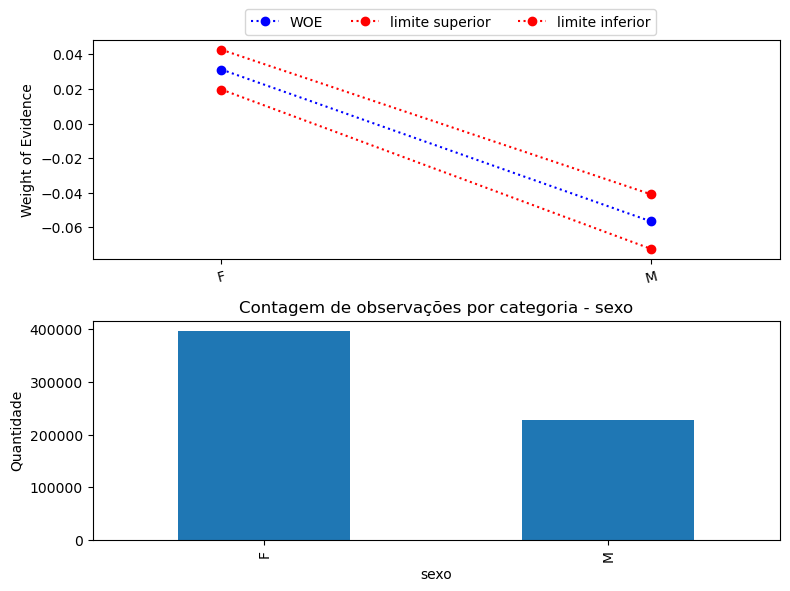

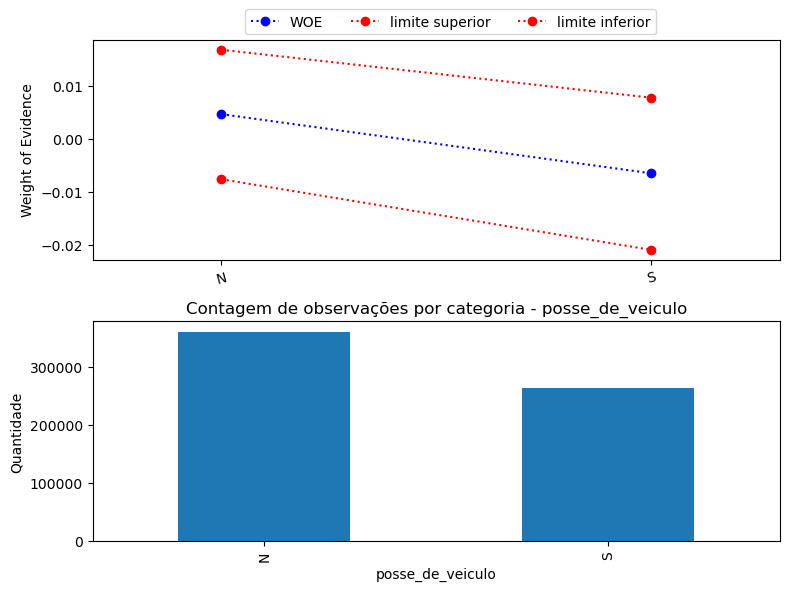

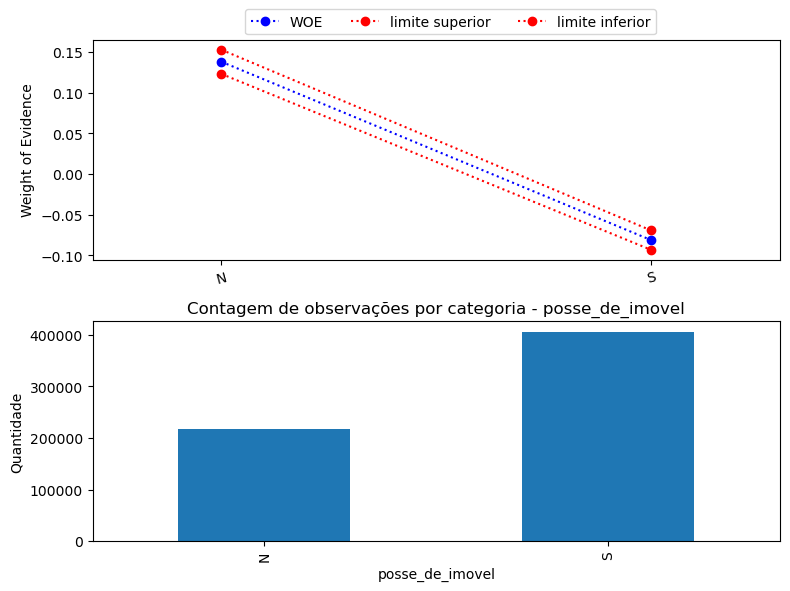

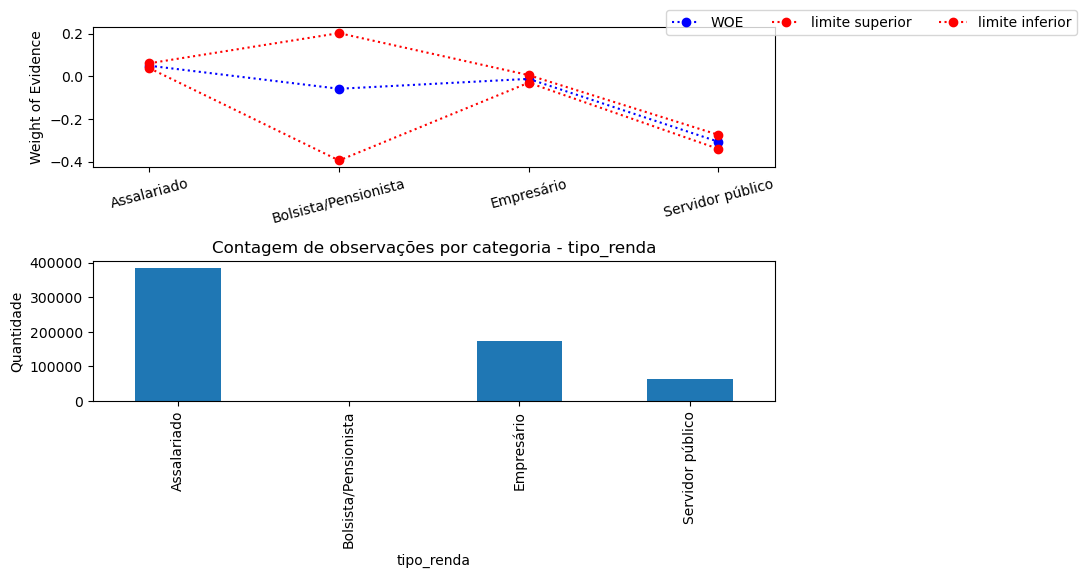

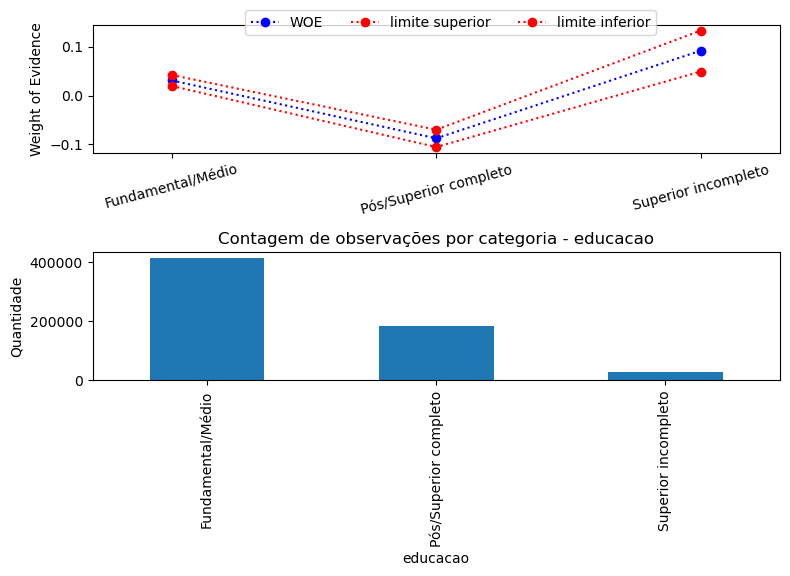

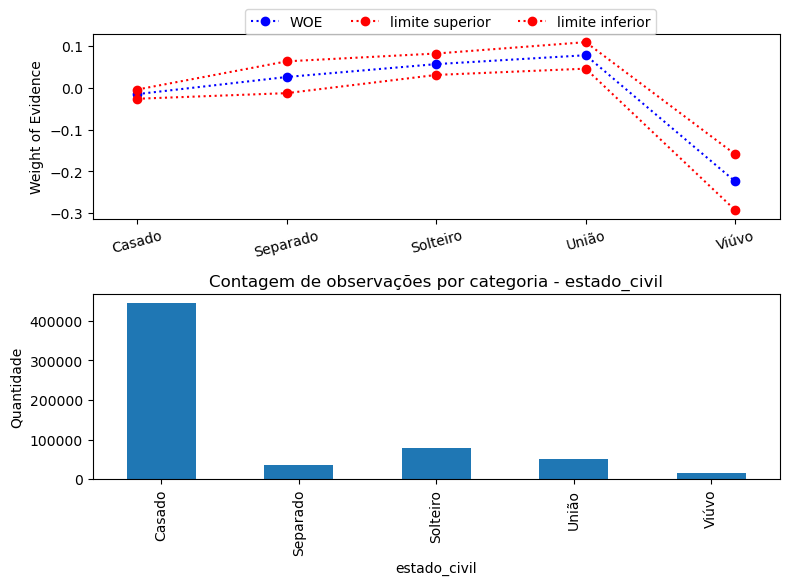

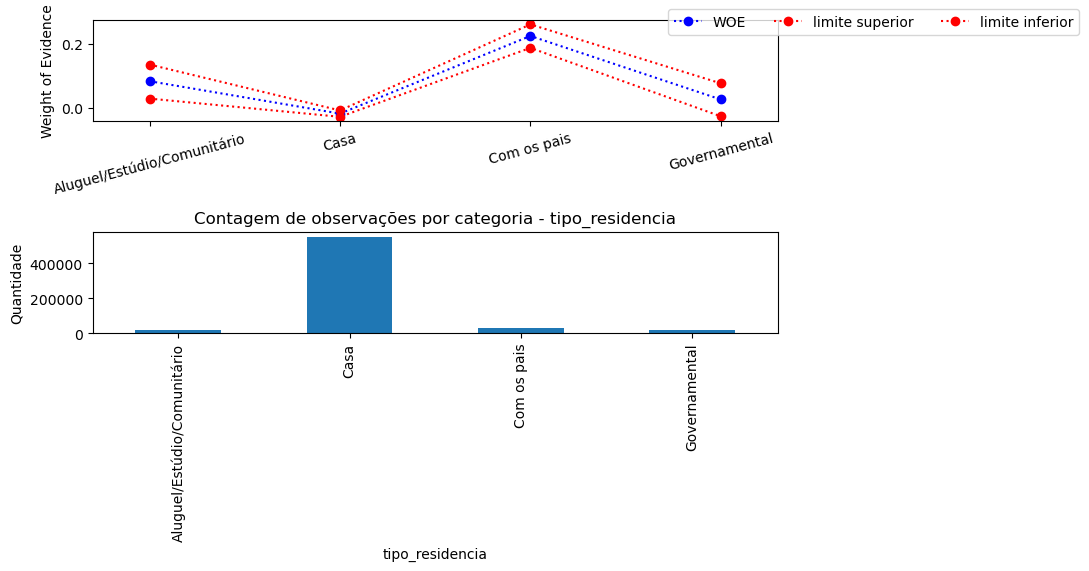

In [39]:
for var in var_qualitativa:
    biv_discreta(var, df_modificado)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [41]:
    # Divisão dos dados conforme o enunciado na primeira etapa 12 - 3

ultimas_3_datas = df_modificado['data_ref'].drop_duplicates().sort_values().unique()[-3:]
df_oot = df_modificado[df_modificado['data_ref'].isin(ultimas_3_datas)].copy()  # Usar .copy() para evitar warnings
df_treino = df_modificado[~df_modificado['data_ref'].isin(ultimas_3_datas)].copy()  # Usar .copy() para evitar warnings

    #  trocar renda por renda_log

var_quantitativa = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda_log']

    # "Configurações do modelo"

# Codificação de variáveis categóricas e normalização de variáveis quantitativas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), var_quantitativa), 
        ('cat', OneHotEncoder(), var_qualitativa)     
    ])

    # Pipeline do modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression())  
])



    # Preparar os dados (treino e oot)

X_treino = df_treino.drop(columns=['mau', 'data_ref'])  
y_treino = df_treino['mau'] 

X_oot = df_oot.drop(columns=['mau', 'data_ref'])  
y_oot = df_oot['mau']  



    # Fit
model.fit(X_treino, y_treino)


    # Previsões

# Previsões na base de treino
y_pred_treino = model.predict(X_treino)
y_pred_proba_treino = model.predict_proba(X_treino)[:, 1]

# Previsões na base out of time
y_pred_oot = model.predict(X_oot)
y_pred_proba_oot = model.predict_proba(X_oot)[:, 1]



    # Avaliações

# Avaliação do modelo na base de treino
accuracy_treino = accuracy_score(y_treino, y_pred_treino)
roc_auc_treino = roc_auc_score(y_treino, y_pred_proba_treino)
fpr_treino, tpr_treino, thresholds_treino = roc_curve(y_treino, y_pred_proba_treino)
ks_treino = np.max(tpr_treino - fpr_treino)
gini_treino = 2 * roc_auc_treino - 1

# Avaliação do modelo na base out of time
accuracy_oot = accuracy_score(y_oot, y_pred_oot)
roc_auc_oot = roc_auc_score(y_oot, y_pred_proba_oot)
fpr_oot, tpr_oot, thresholds_oot = roc_curve(y_oot, y_pred_proba_oot)
ks_oot = np.max(tpr_oot - fpr_oot)
gini_oot = 2 * roc_auc_oot - 1

    # Métricas

# Exibir métricas na base de treino
print("Métricas na base de treino:\n")
print(f"Acurácia: {accuracy_treino:.4f}")
print(f"AUC-ROC: {roc_auc_treino:.4f}")
print(f"KS: {ks_treino:.4f}")
print(f"Gini: {gini_treino:.4f}")

# Exibir métricas na base out of time
print("\\nnMétricas na base out of time:\n")
print(f"Acurácia: {accuracy_oot:.4f}")
print(f"AUC-ROC: {roc_auc_oot:.4f}")
print(f"KS: {ks_oot:.4f}")
print(f"Gini: {gini_oot:.4f}")

Métricas na base de treino:

Acurácia: 0.9397
AUC-ROC: 0.7782
KS: 0.4117
Gini: 0.5563
\nnMétricas na base out of time:

Acurácia: 0.8568
AUC-ROC: 0.7490
KS: 0.3639
Gini: 0.4980


## Avaliação das métricas

### **Base de treino**

- **Acurácia: 0.9397**  
  Muito alta, o que é esperado em um modelo ajustado na base de treino. Pode indicar um bom ajuste, mas também levanta a hipótese de leve overfitting, principalmente se comparado à base out of time.  

- **AUC-ROC: 0.7782**  
  Um valor bom (acima de 0.75 já é considerado razoável), mostra que o modelo tem boa capacidade de separação entre as classes.  

- **KS: 0.4117**  
  Um KS acima de 0.4 é ótimo! Isso indica que o modelo está conseguindo separar bem bons e maus pagadores.  

- **Gini: 0.5563**  
  Um Gini acima de 0.5 é considerado bom. Esse resultado mostra um bom poder discriminatório na base de treino.  

### **Base out of time (validação temporal)**

In [ ]:
- **Acurácia: 0.8568**  
  Caiu em relação à base de treino, o que é esperado. Ainda assim, 85% é um bom resultado, mas mostra uma queda notável de performance.  

- **AUC-ROC: 0.7490**  
  Ainda aceitável. O modelo continua com uma capacidade razoável de separação, mas houve uma leve perda.  

- **KS: 0.3639**  
  Um KS acima de 0.35 na base out of time ainda é considerado bom. Mostra que o modelo não perdeu tanto poder de separação ao longo do tempo.  

- **Gini: 0.4980**  
  Quase 0.5, o que é bom. Ainda demonstra discriminação aceitável no período fora do treino. 

### **Análise geral**

- Há sim um desgaste na performance quando vamos para a base out of time, mas não é uma queda drástica.  
- O modelo parece **estável e consistente**, ainda conseguindo discriminar bem.  
- A diferença entre o KS treino (0.41) e out of time (0.36) é relativamente pequena.  
- A principal recomendação seria:  
  - Continuar monitorando esse modelo ao longo do tempo para ver se o decaimento de performance continua.  
  - Se for um modelo que será usado em produção, a performance está aceitável, mas um retraining ou reavaliação a cada alguns meses pode ser interessante.  
